<a href="https://colab.research.google.com/github/lunacandido/deep_learning_pytorch_luna/blob/main/trainingneuralnetworks_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Otimização e Taxa de Aprendizado

Objetivo : minimizar a função de perda

Para isso podemos alterar os pesos do modelo e verificar seu impacto na função de perda
Neste sentido com redes de múltiplas dimensões, usa-se vetor de derivadas parciais para calcular o indicador, conhecido por 'gradiente', para saber se o modelo melhorou ou piorou com base em uma medida de qualidade (loss).

A otimização usa a informação do 'gradiente' para escolher os próximos passos que leva ao ponto mínimo da superfície do erro.

Basicamente o fluxo de treinamento se resume em 4 partes principais:

- Opera entrada na rede;

- Cálculo da função de perda;

- Cáculo do gradiente;

- Atualização dos pesos.

E assim se segue até obter o ponto mínimo da superfície de erro.

Descida do gradiente é um termo bem importante. Consiste em subtrair o valor do gradiente, dos pesos da rede. Se tem pesos qualquer, só se subtrai esse peso pelo gradiente, dado que tem um multiplicador.

A Taxa de aprendizado fica a escolha do pesquisador. Se a taxa de aprendizado é grande, o modelo vai convergir e depois acaba por divergir. Se está alta, mas não muito, o modelo vai saturar em um ponto ruim. Taxa alta não consegue ajustar de forma criteriosa logo seu modelo não estabiliza.
Uma boa taxa é aquela que decresce rapidamente e satura num ponto ótimo, próximo de zero.

## Otimizando a rede no Pytorch

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


Text(0, 0.5, 'color_intensity')

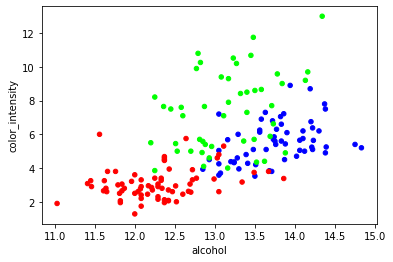

In [20]:
# funções para fazer os passos de otimização
# usando os atributos teor alcólico(0) e intensidade da cor(9)
from sklearn import datasets
import matplotlib.pyplot as plt

features = [0, 9]

wine = datasets.load_wine()
data = wine.data[:, features]
targets = wine.target

print(wine.feature_names)

plt.scatter(data[:, 0], data[:,1], c=targets, s=20, cmap=plt.cm.brg)
plt.xlabel(wine.feature_names[features[0]])
plt.ylabel(wine.feature_names[features[1]])

Text(0, 0.5, 'color_intensity')

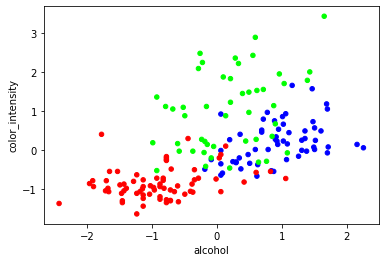

In [25]:
# Normalização dos dados : colocando-os em intervalos numéricos mais parecidos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data)

plt.scatter(data[:, 0], data[:,1], c=targets, s=20, cmap=plt.cm.brg)
plt.xlabel(wine.feature_names[features[0]])
plt.ylabel(wine.feature_names[features[1]])

cpu


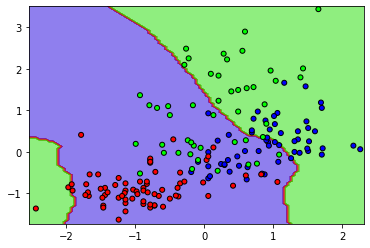

In [36]:
# intanciar a rede
import torch 
from torch import nn
torch.manual_seed(42)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(device)
input_size = data.shape[1] # numero de caracteristica
hidden_size = 32  ## quantidade de neuronios
output_size = len(wine.target_names) ## numero de classes

net = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size),
    nn.Softmax()
)

net = net.to(device) ## sobe no cast

## visualizar o modelo , suas fronteiras de decisão

import numpy as np

def plot_boundary(X, y, model):
  x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
  y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
  
  spacing = min(x_max - x_min, y_max - y_min) / 100
  
  XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                       np.arange(y_min, y_max, spacing))
  
  data = np.hstack((XX.ravel().reshape(-1,1), 
                    YY.ravel().reshape(-1,1)))
  
  # For binary problems
  # db_prob = model(Variable(torch.Tensor(data)).cuda() )
  # clf = np.where(db_prob.cpu().data < 0.5,0,1)
  
  # For multi-class problems
  db_prob = model(torch.Tensor(data).to(device) )
  clf = np.argmax(db_prob.cpu().data.numpy(), axis=-1)
  
  Z = clf.reshape(XX.shape)
  
  plt.contourf(XX, YY, Z, cmap=plt.cm.brg, alpha=0.5)
  plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', s=25, cmap=plt.cm.brg)

plot_boundary(data, targets, net)

In [37]:
# Otimizando o modelo

from torch import optim ## pacote de otimzação do pytorch

# Função de Perda

criterion = nn.CrossEntropyLoss().to(device)


# Otimizador: Descida do Gradiente
# Stochastic Gradient Descent

optimizer = optim.SGD(net.parameters(), lr=1e-3)
# lr = taxa de aprendizado 
# net.parameters = parametro
# usa-se abordagem dos pandas - modificando os hiperparâmetros para ir testando em um único modelo


Observação

Tem-se dois tipos de busca do hiperparâmetro, são eles:

- Empírica (Panda): O programador trabalha com um único modelo, e altera os hiperparâmetros com base na experiência e nas observações

- Experimental: Múltiplos modelos são gerados simultaneamente, com diferentes combinações de hiperparâmetros. O escolhido é o que apresentar melhor performance.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


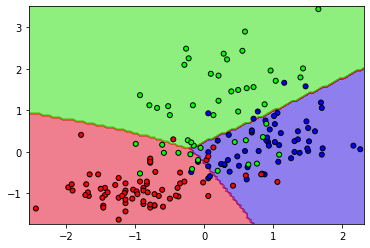

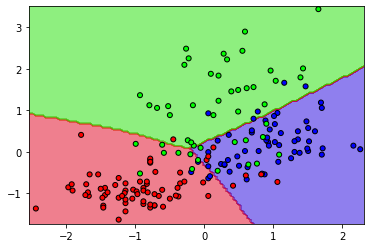

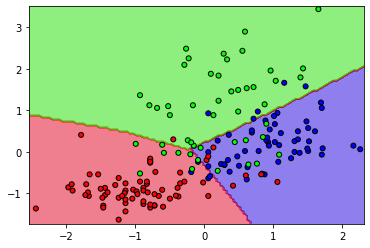

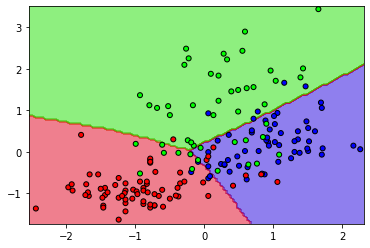

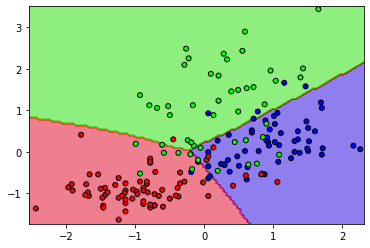

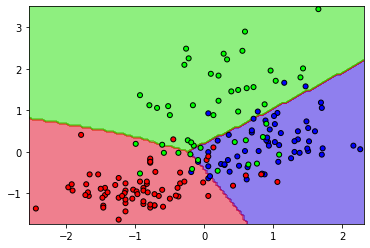

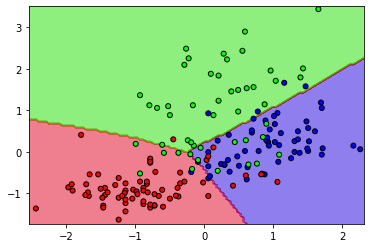

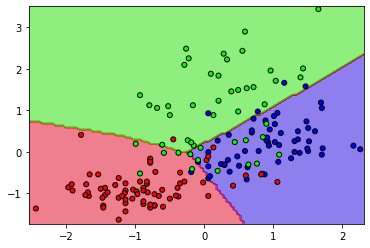

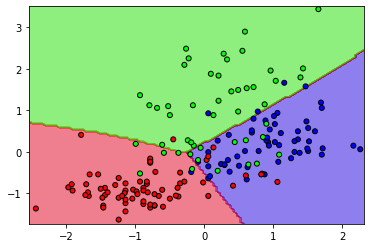

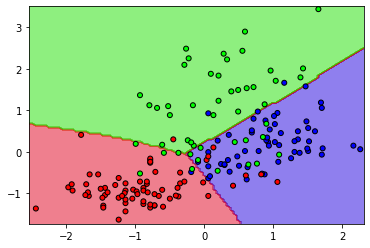

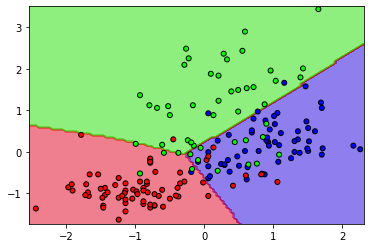

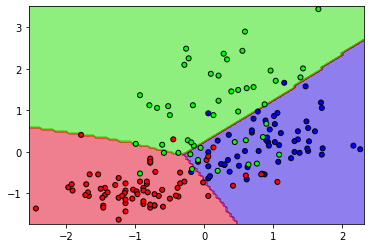

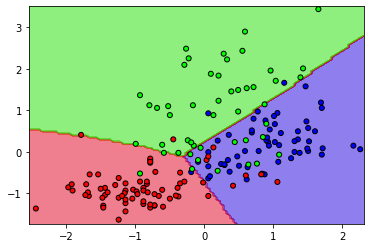

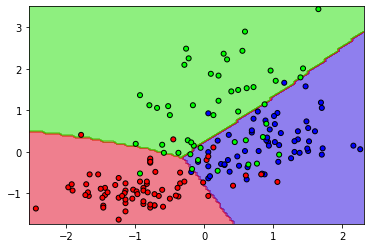

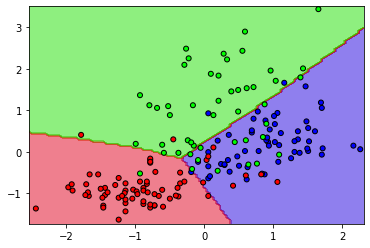

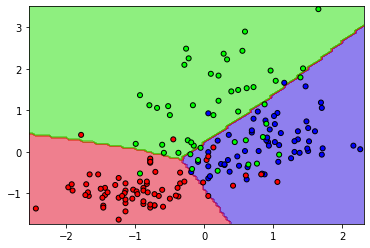

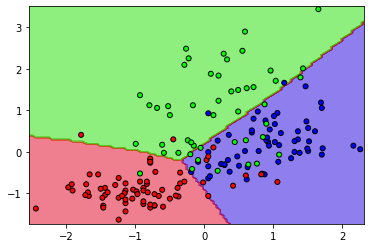

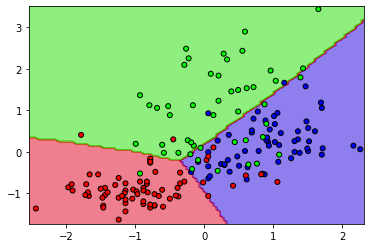

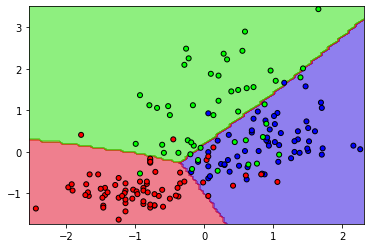

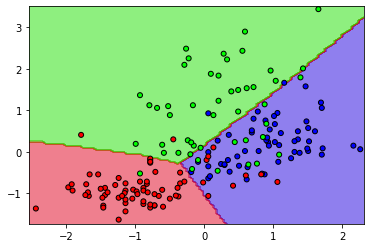

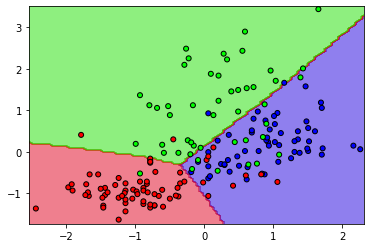

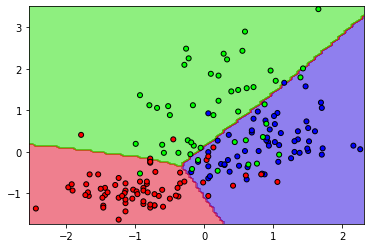

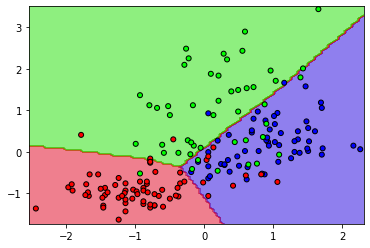

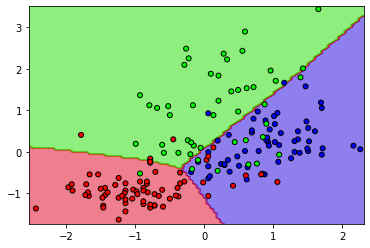

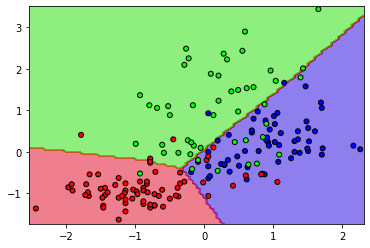

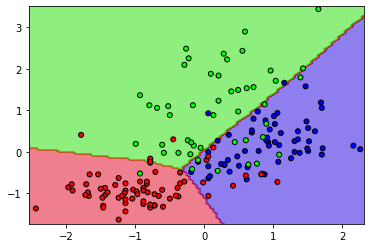

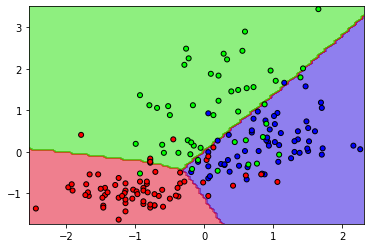

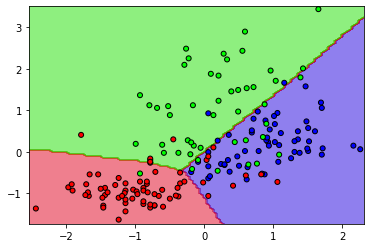

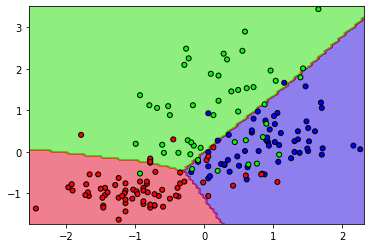

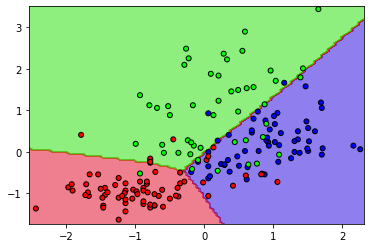

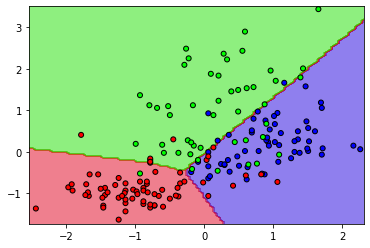

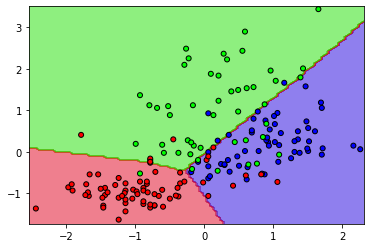

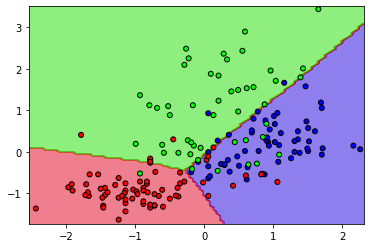

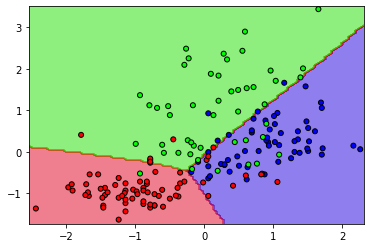

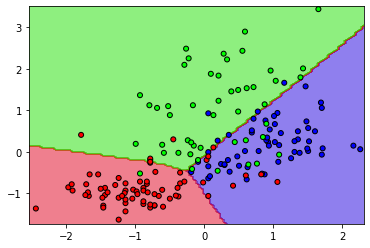

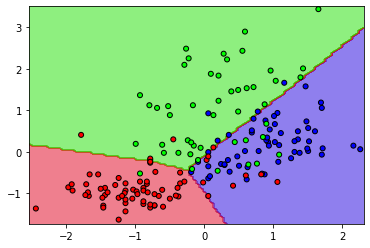

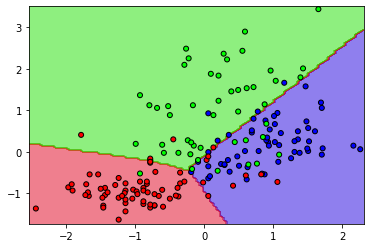

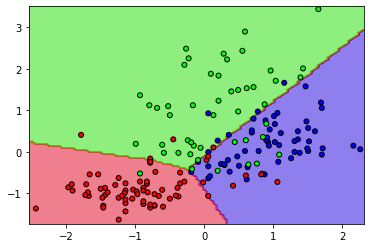

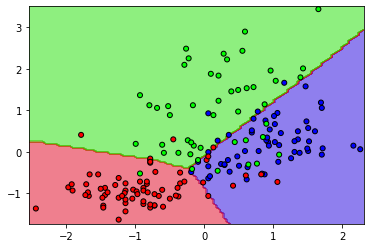

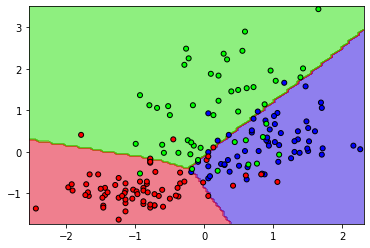

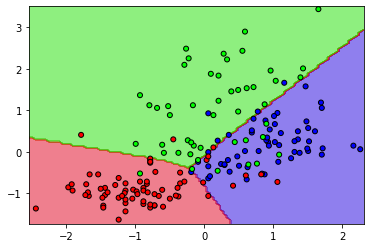

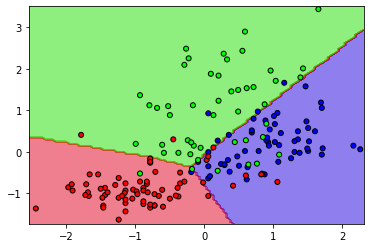

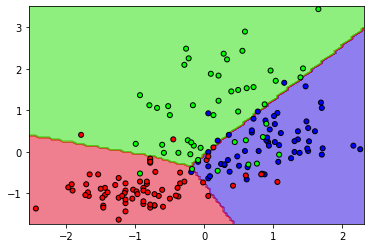

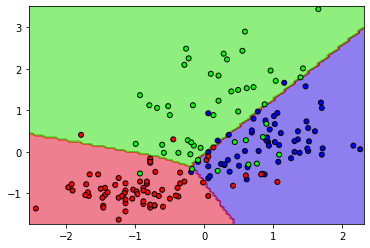

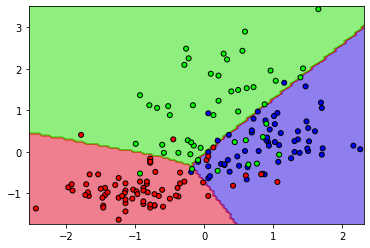

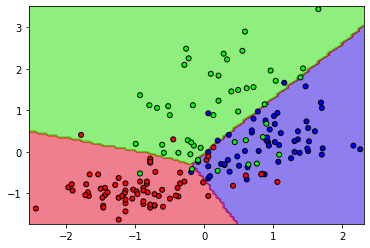

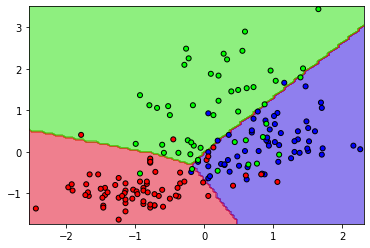

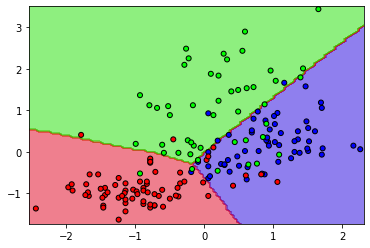

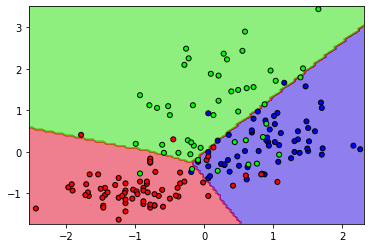

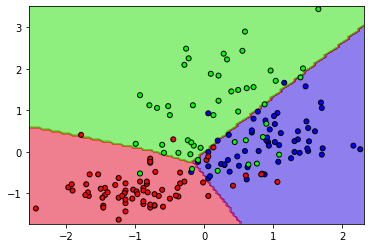

In [40]:
# transformar os dados em tensores e já subindo no cast
X = torch.FloatTensor(data).to(device) 
Y = torch.LongTensor(targets).to(device)

## treinando a rede
for i in range(500):
# Forward 
  pred = net(X)
  loss = criterion(pred, Y)

# Backward
  loss.backward() ## calcula a derivada do loss = gradiente
  optimizer.step()

  if i % 10 == 0:
    plt.figure()
    plot_boundary(data, targets, net)

A otimização é um processo iterativo, os dados devem ser alimentados várias vezes para o modelo. Cada iteração recebe o nome de **época**.